In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../src/cot/train.py --n_head 1 --n_layer 2 --nb_epochs 500 --nb_len 12 --load_checkpoint False

INFO:cot.data.data_processing:Generating data. Saving in /private/home/vivc/code/llm/cot/data/raw/binary_copy
INFO:cot.data.data_processing:Loading training data for binary_copy problem.
INFO:cot.data.data_processing:Setting sampler.
INFO:cot.data.data_processing:Loading test data for binary_copy problem.
INFO:__main__:Number of training data: 4095.
INFO:__main__:Model: Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(27, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, o

## Looking at the evaluation metrics

In [3]:
import matplotlib.pyplot as plt
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECKPOINT_DIR

problem = BinaryCopy

path = CHECKPOINT_DIR / problem.prefix / 'model.pth'

checkpoint = torch.load(path)

evals = checkpoint["evals"]
ind = evals != -1
evals = evals[ind]

eval = checkpoint["evals"].argmax() + 1

acc_by_len = checkpoint["acc_by_len"][ind]
test_acc_by_len = checkpoint["test_acc_by_len"][ind]
spe_acc = checkpoint["spe_acc"][ind]
test_spe_acc = checkpoint["test_spe_acc"][ind]
losses = checkpoint["losses"]

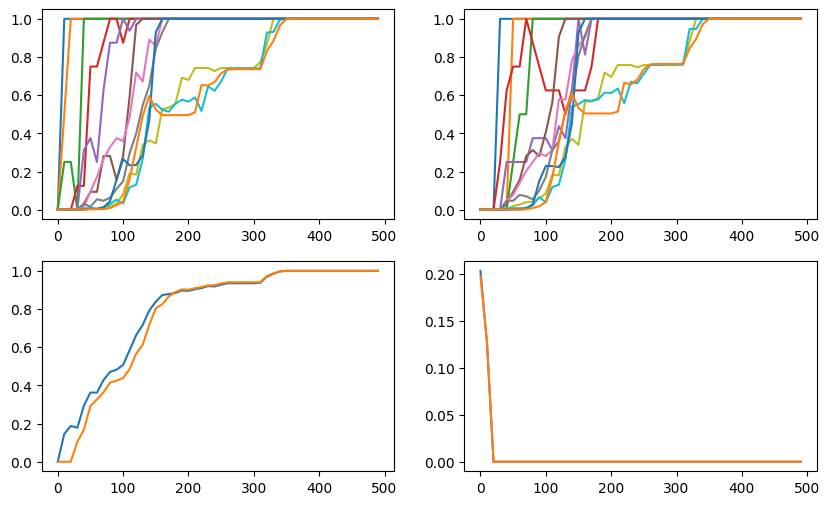

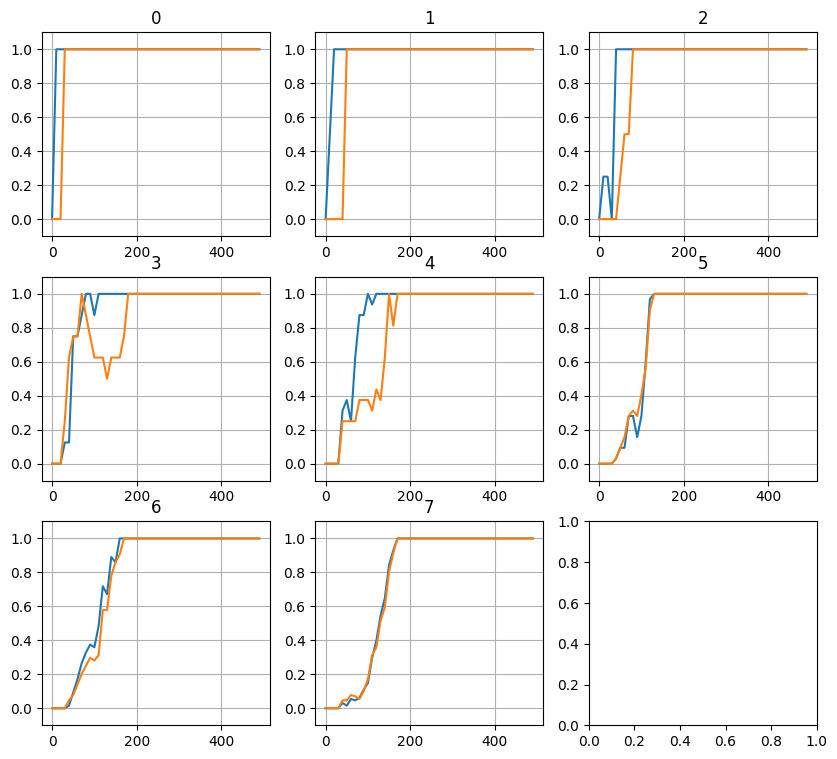

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].plot(evals, acc_by_len)
axes[0, 1].plot(evals, test_acc_by_len)
axes[1, 0].plot(evals, acc_by_len.mean(axis=1))
axes[1, 0].plot(evals, test_acc_by_len.mean(axis=1))
axes[1, 1].plot(evals, spe_acc[:, 2])
axes[1, 1].plot(evals, test_spe_acc[:, 2])
# axes[1, 1].set_xlim(0, 50)

nb_len = 8
fig, axes = plt.subplots(nb_len // 3 + (1 if nb_len % 3 else 0), 3, figsize=(10, 9))
for i in range(nb_len):
    axes[i // 3, i % 3].plot(evals, acc_by_len[:, i])
    axes[i // 3, i % 3].plot(evals, test_acc_by_len[:, i])
    axes[i // 3, i % 3].set_ylim(-.1, 1.1)
    axes[i // 3, i % 3].set_title(i)
    axes[i // 3, i % 3].grid()

## Looking at the model

In [9]:
import numpy as np
from numpy.linalg import svd
from cot.models import TransformerConfig, Transformer

nb_len=12
emb_dim=128
n_head=1
n_layer=2
device='cuda'

In [6]:
token_emb = checkpoint['model_state_dict']['embeddings.token_emb.weight'].cpu()
pos_emb = checkpoint['model_state_dict']['embeddings.pos_emb.weight'].cpu()

In [10]:
lengths = list(np.arange(nb_len) + 1)

testset = problem()
testset.set_as_testset(lengths)

INFO:cot.data.data_processing:Loading test data for binary_copy problem.


In [11]:
config = TransformerConfig(
    vocab_size=torch.max(testset.data).item() + 1,
    emb_dim=emb_dim,
    pos_emb=True,
    seq_len=len(testset[0]),
    emb_dropout=0,
    n_head=n_head,
    n_layer=n_layer,
)

model = Transformer(config)
model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device=device)
model.eval()

Transformer(
  (embeddings): Embedding(
    (token_emb): Embedding(5, 128)
    (pos_emb): Embedding(27, 128)
  )
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_mat): Linear(in_features=128, out_features=384, bias=False)
        (output): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=False)
        (fc2): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (output_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=5, bias=False)
)

In [12]:
sequence = testset.data
# sequence = sequence.to(device=device, dtype=torch.long)

with torch.no_grad():
    logits, attentions = model(sequence, verbose=True)

In [13]:
sequence.shape

torch.Size([4095, 27])

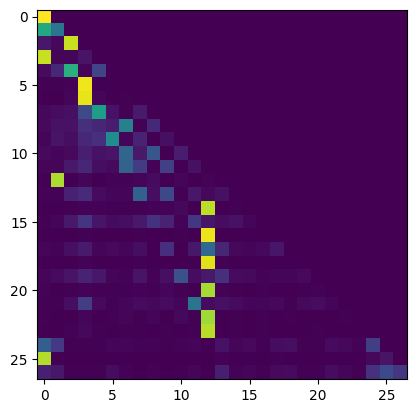

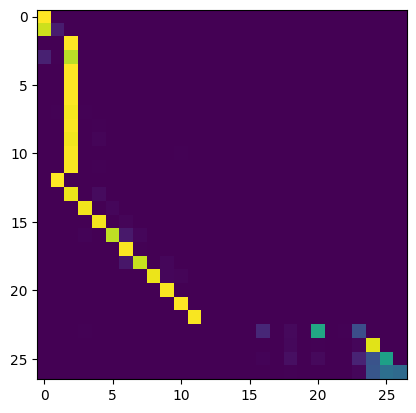

In [18]:
plt.imshow(attentions[0, 2**10 + 10, 0].cpu())
plt.figure()
plt.imshow(attentions[1, 2**10 + 10, 0].cpu())